# Investigating which areas show significant second level effects at which times

In [1]:
%matplotlib notebook
import numpy as np
import helpers
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import source_visualisations as sv
import source_statistics as ss
import mne

## Data preparation
Which data?

In [60]:
# baseline [-0.3, 0], trialregs_dot=5
# basefile = 'source_HCPMMP1_allsubs_201703301614.h5'

# baseline None, trialregs_dot=5
#basefile = 'source_HCPMMP1_allsubs_201706091054.h5'

# baseline (-0.3, 0), trialregs_dot=5, GLM in source space
#basefile = 'source_sequential_201706141650.h5'

# baseline (-0.3, 0), trialregs_dot=5, GLM in source space, move_dist, sum_dot_y
#basefile = 'source_sequential_201706191442.h5'

# baseline (-0.3, 0), trialregs_dot=5, GLM in source space, move_dist, 
# sum_dot_y, constregs=0 for 1st dot
#basefile = 'source_sequential_201706201654.h5'

# baseline (-0.3, 0), only first 3 dots, trialregs_dot=3, GLM in source space, move_dist, 
# sum_dot_y, constregs=0 for 1st dot
#basefile = 'source_sequential_201706261151.h5'

# label mode = (abs)max, baseline (-0.3, 0), only first 3 dots, trialregs_dot=3, GLM in source space, 
# move_dist, sum_dot_y, constregs=0 for 1st dot
#basefile = 'source_sequential_201706281100.h5'

# baseline (-0.3, 0), only first 3 dots, trialregs_dot=3, move_dist, 
# sum_dot_y, constregs=0 for 1st dot, 
# label_tc normalised across trials, times and subjects
#basefile = 'source_sequential_201707031206.h5'

# label mode = mean, baseline (-0.3, 0), only first 3 dots, 
# trialregs_dot=3, source GLM, move_dist, sum_dot_y, constregs=0 for 1st dot, 
# label_tc normalised across trials, times and subjects
#basefile = 'source_sequential_201708241011.h5'

# label mode = mean, baseline (-0.3, 0), only first 3 dots, 
# trialregs_dot=0, source GLM, sum_dot_y, motoprep, constregs=0 for 1st dot, 
# subject-specific normalisation of DM without centering and scaling by std
# label_tc normalised across trials, times and subjects
basefile = 'source_sequential_201709011758.h5'

# label mode = mean, baseline (-0.3, 0), first 5 dots, 
# trialregs_dot=0, source GLM, sum_dot_y, constregs=0 for 1st dot, 
# subject-specific normalisation of DM without centering and scaling by std
# label_tc normalised across trials, times and subjects
#basefile = 'source_sequential_201709061827.h5'

choose measure and identify threshold

In [61]:
# e.g.: mu_p_large, mu_testval, mu_t, mu_mean
#measure = 'mu_mean'
measure = 'mu_p_large'

# which regressors should define the empirical value distribution?
# set regressors = None for all
regressors = ['accev', 'dot_x', 'dot_y', 'abs_dot_x', 'abs_dot_y', 'sum_dot_y_prev']
#regressors = ['motoprep', 'response', 'trial_time', 'entropy']

# do not use these regressors to define empirical value distribution
#exclude = 'trialregs'
#exclude = 'dotregs'

# the empiric error threshold for a single time point and area
# (the selected threshold will be the quantile 1-alpha of the 
# empirical distribution of measure values)
alpha = 0.05

threshold, measure_cdf = ss.find_slabs_threshold(
    basefile, measure, quantile=1-alpha, regressors=regressors, 
    verbose=1, return_cdf=True)

print('\nthreshold = {:.4f}'.format(threshold))

adding accev
adding dot_x
adding dot_y
adding abs_dot_x
adding abs_dot_y
adding sum_dot_y_prev
N = 152040

threshold = 0.5375


what are large values for the possible measures (used for setting y-lim in plotting)

In [27]:
ylims = {'mu_p_large': 1, 'mu_t': 8, 'mu_z': 8, 'mu_testval': 0.02, 'mu_mean': 0.04}
logy = {'mu_p_large': False, 'mu_t': False, 'mu_z': False, 'mu_testval': True, 'mu_mean': False}

## Load data for all selected regressors and identify significant clusters in time
The idea is that you identify sequences of high measure values that cannot happen by chance. This is all based on the empirical measure distribution used above. This distribution defines the probability with which I would get a particular measure value, if I were to draw one randomly across locations, time points and regressors. So it is a permutation distribution. I then use the cumulative density function of this distribution to first select a cluster threshold, i.e., a measure value which has to be exceeded in order to form a sequence cluster. Then I identify clusters, i.e., sequences of measure values within an area that exceed the threshold. The p-value of the found cluster is the product of 1-cdf(value) for the measure values in the sequence.

In [62]:
clusters = ss.get_fdrcorr_clusters(basefile, regressors, measure, threshold, measure_cdf,
                                   fdr_alpha=0.001)

print('cluster counts:')
print(clusters.label.groupby(level='regressor').count())

clusters.sort_values('start_t').sort_index(level='regressor', sort_remaining=False)

cluster counts:
regressor
accev             262
dot_x             211
dot_y              42
abs_dot_x          26
abs_dot_y          16
sum_dot_y_prev     26
Name: label, dtype: int64


label  start_t  end_t     log10p  \
regressor      cluster                                              
accev          314        L_PCV_ROI-lh        0     40  -8.580536   
               1029       R_V3B_ROI-rh        0     40  -8.410695   
               959       R_ProS_ROI-rh        0     40  -8.977830   
               938       R_POS2_ROI-rh        0     30  -6.245508   
               361       L_ProS_ROI-lh        0     40  -9.209287   
               848        R_MIP_ROI-rh       10     40  -6.709118   
               667        R_5mv_ROI-rh       10     40  -5.563487   
               773        R_DVT_ROI-rh       10     30  -4.067095   
               428        L_V3A_ROI-lh       10     20  -4.557106   
               417         L_V1_ROI-lh       10     40  -9.957239   
               431        L_V3B_ROI-lh       10     40  -8.146795   
               936       R_POS1_ROI-rh       10     30  -6.654749   
               1012        R_V1_ROI-rh       10     30  -7.109519   
               1058        R_V6_ROI-rh       20    390 -83.564941   
               66        L_31pv_ROI-lh       20     50  -7.058875   
               211       L_FOP3_ROI-lh       20     50  -5.605754   
               63        L_31pd_ROI-lh       30     60  -6.913261   
               340         L_PI_ROI-lh       30     40  -4.046061   
               706         R_7m_ROI-rh       30    390 -82.960961   
               600       R_31pd_ROI-rh       30     60  -6.860849   
               763        R_AIP_ROI-rh       30     50  -4.809969   
               97           L_4_ROI-lh       40     70  -6.969730   
               159         L_7m_ROI-lh       40    380 -76.272973   
               597        R_31a_ROI-rh       40     60  -4.362545   
               1061        R_V7_ROI-rh       40    140 -21.697616   
               1163     R_v23ab_ROI-rh       40    450 -97.318861   
               813        R_IP0_ROI-rh       50     90  -8.128698   
               824       R_IPS1_ROI-rh       50     70  -4.491395   
               838       R_LIPv_ROI-rh       50     70  -6.184653   
               1134     R_p32pr_ROI-rh       50     70  -5.140225   
...                                ...      ...    ...        ...   
abs_dot_y      132       L_ProS_ROI-lh      330    340  -4.076448   
               330      R_TPOJ3_ROI-rh      350    370  -4.130449   
               100         L_MT_ROI-lh      410    430  -4.355215   
               82        L_IPS1_ROI-lh      490    510  -5.344181   
sum_dot_y_prev 205       L_POS2_ROI-lh       10    110 -19.296856   
               606         R_V6_ROI-rh       10     30  -4.484790   
               612         R_V7_ROI-rh       50     90  -9.307834   
               407        R_DVT_ROI-rh       50    100 -10.765921   
               498        R_PGp_ROI-rh       50     90  -9.313781   
               427        R_IP0_ROI-rh       50    100 -12.111391   
               525       R_POS2_ROI-rh       50    100 -11.844801   
               518       R_POS1_ROI-rh       60    100  -9.890548   
               141       L_IPS1_ROI-lh       60     80  -4.542219   
               202       L_POS1_ROI-lh       60    100 -10.524661   
               347       R_31pv_ROI-rh       60     90  -6.029433   
               436       R_IPS1_ROI-rh       60     90  -6.911232   
               603        R_V6A_ROI-rh       70     90  -4.525089   
               345        R_31a_ROI-rh       70     90  -4.588544   
               499        R_PGp_ROI-rh      140    170  -6.965881   
               428        R_IP0_ROI-rh      160    180  -4.396015   
               203       L_POS1_ROI-lh      210    240  -6.817682   
               124       L_FOP4_ROI-lh      270    290  -5.129984   
               206       L_POS2_ROI-lh      270    290  -4.730991   
               482      R_PBelt_ROI-rh      450    460  -4.255776   
               435        R_IP2_ROI-rh      510    530  -4.458905   
               555        R_RSC

## Find all clusters of a given area or region

In [29]:
area = 'v23ab'
clusters[clusters.label.apply(lambda s: s.find(area) >= 0)]

label  start_t  end_t      log10p  pval_corrected  \
regressor cluster                                                               
accev     340      L_v23ab_ROI-lh       40    450  -94.979539    3.485398e-93   
          732      R_v23ab_ROI-rh       40    470 -101.229517    3.920163e-99   
dot_x     184      L_v23ab_ROI-lh      110    130   -6.749869    1.391661e-06   
          185      L_v23ab_ROI-lh      150    200  -12.898303    1.910144e-12   
          186      L_v23ab_ROI-lh      290    490  -53.393346    4.032433e-52   
          388      R_v23ab_ROI-rh      110    120   -5.144084    4.114146e-05   
          389      R_v23ab_ROI-rh      150    200  -12.186105    9.417993e-12   
          390      R_v23ab_ROI-rh      290    490  -54.272387    5.919477e-53   

                                       region  
regressor cluster                              
accev     340      posterior cingulate cortex  
          732      posterior cingulate cortex  
dot_x     184      posterior cingulate cortex  
          185      posterior cingulate cortex  
          186      posterior cingulate cortex  
          388      posterior cingulate cortex  
          389      posterior cingulate cortex  
          390      posterior cingulate cortex

In [30]:
region = 'frontal'
clusters[clusters.region.apply(lambda s: s.find(region) >= 0)]

label  start_t  end_t     log10p  \
regressor      cluster                                              
accev          11         L_13l_ROI-lh      190    240  -8.808861   
               33          L_25_ROI-lh      350    380  -6.001542   
               34          L_25_ROI-lh      400    480 -14.494543   
               49        L_33pr_ROI-lh      130    160  -5.790097   
               50        L_33pr_ROI-lh      190    400 -45.947160   
               107        L_8Ad_ROI-lh      220    290 -12.108025   
               108        L_8BM_ROI-lh      210    260  -9.348797   
               117        L_AVI_ROI-lh      460    480  -4.430053   
               131       L_IFJp_ROI-lh      200    220  -3.991820   
               255        L_SFL_ROI-lh      370    380  -4.150752   
               310        L_a24_ROI-lh      450    490  -8.257455   
               312      L_a24pr_ROI-lh      200    230  -6.183193   
               313      L_a24pr_ROI-lh      320    380 -10.303664   
               315      L_a32pr_ROI-lh      210    230  -4.508763   
               316      L_a32pr_ROI-lh      250    270  -4.401976   
               323      L_p24pr_ROI-lh      200    230  -6.896404   
               325      L_p24pr_ROI-lh      320    400 -14.060822   
               330      L_p32pr_ROI-lh      190    290 -18.319223   
               331      L_p32pr_ROI-lh      320    370  -9.885259   
               338        L_s32_ROI-lh      460    480  -5.595388   
               360         R_25_ROI-rh      350    380  -6.293622   
               361         R_25_ROI-rh      400    490 -18.150973   
               376       R_33pr_ROI-rh      190    230  -8.302689   
               377       R_33pr_ROI-rh      270    300  -5.868923   
               378       R_33pr_ROI-rh      320    350  -6.197757   
               443         R_9a_ROI-rh      170    200  -6.591039   
               452         R_9m_ROI-rh      220    250  -6.517057   
               513         R_Ig_ROI-rh      290    310  -4.345622   
               600       R_PoI2_ROI-rh      440    480  -7.922990   
               692      R_a24pr_ROI-rh      130    160  -5.903819   
               693      R_a24pr_ROI-rh      190    400 -38.699673   
               695      R_a32pr_ROI-rh      210    230  -4.336997   
               710      R_p24pr_ROI-rh      130    170  -8.295175   
               711      R_p24pr_ROI-rh      190    490 -67.860057   
               715      R_p32pr_ROI-rh      190    400 -39.689604   
               723        R_s32_ROI-rh      140    150  -3.718194   
               726        R_s32_ROI-rh      380    420  -7.975191   
               727        R_s32_ROI-rh      440    490  -9.752678   
               730       R_s6-8_ROI-rh      350    390  -8.354120   
dot_x          29        L_33pr_ROI-lh      310    490 -35.730532   
               178      L_p24pr_ROI-lh      420    490 -13.078470   
               217       R_33pr_ROI-rh      390    480 -16.209134   
               224         R_52_ROI-rh      410    440  -5.992970   
               279         R_Ig_ROI-rh      400    450  -9.674569   
               280         R_Ig_ROI-rh      470    490  -4.546581   
               371      R_a24pr_ROI-rh      310    370 -11.168563   
               372      R_a24pr_ROI-rh      400    490 -17.673119   
               380      R_p24pr_ROI-rh      310    490 -39.676714   
               384      R_p32pr_ROI-rh      390    490 -18.523369   
abs_dot_y      76          R_MI_ROI-rh      280    290  -3.772453   
sum_dot_y_prev 62          L_8C_ROI-lh      300    340  -7.143937   
               92        L_IFSp_ROI-lh      210    230  -4.561134   
               261        R_11l_ROI-rh      380    390  -3.668367   
               286        R_47m_ROI-rh      270    290  -5.370177   
               335       R_IFSa_ROI-rh      320    340  -4.512301   
               336       R_IFSa_ROI-rh      370    390  -4.680610   
               463       R_a47r

## Investigate individual regressors

In [63]:
r_name = 'accev'
#r_name = 'trial_time'
r_clusters = clusters.xs(r_name, level='regressor').copy()

src_df = ss.load_src_df(basefile, r_name)

### Check the times at which we see significant clusters

<IPython.core.display.Javascript object>


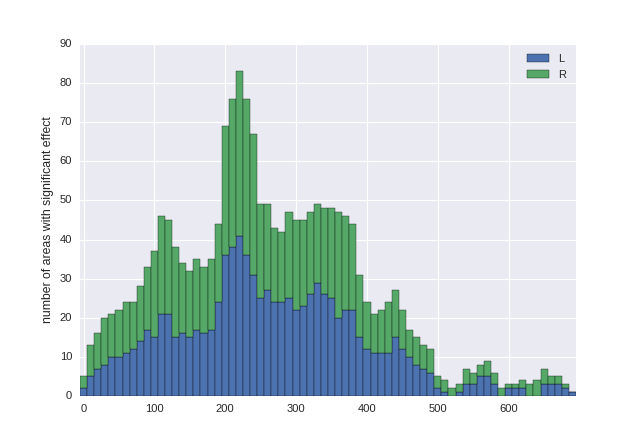

In [64]:
times = src_df[measure].index.levels[1]
sigareas = r_clusters.label.unique()
significant = pd.DataFrame(np.zeros((sigareas.size, times.size), bool), 
                           index=sigareas, columns=times)
for row in r_clusters.itertuples():
    significant.loc[row.label, slice(row.start_t, row.end_t)] = True
    
fig, ax = plt.subplots()
left = significant.columns - 5
colors = plt.rcParams['axes.prop_cycle']._left

# plot left hemi 
numlh = significant[significant.index.map(lambda l: l[0]) == 'L'].sum()
ax.bar(left, height=numlh, width=10, bottom=0, color=colors[0]['color'])
# plot right hemi
ax.bar(left, 
       height=significant[significant.index.map(lambda l: l[0]) == 'R'].sum(), 
       width=10, bottom=numlh, color=colors[1]['color'])
ax.set_ylabel('number of areas with significant effect');
ax.legend(['L', 'R']);
ax.set_xlim(left[0], left[-1]+10);

### Count number of time points at which areas are in significant cluster

In [65]:
atmp = significant.sum(axis=1).sort_values(ascending=False)
atmp = pd.concat([atmp, pd.Series(list(map(ss.get_Glasser_section, atmp.index)), index=atmp.index)], 
                 axis=1, keys=['count', 'region'])
print(atmp.head(20))
del atmp

                count                          region
L_4_ROI-lh         44  somatosensory and motor cortex
R_v23ab_ROI-rh     42      posterior cingulate cortex
L_v23ab_ROI-lh     40      posterior cingulate cortex
R_3a_ROI-rh        38  somatosensory and motor cortex
R_V6_ROI-rh        38     dorsal stream visual cortex
R_7m_ROI-rh        37      posterior cingulate cortex
R_V7_ROI-rh        36     dorsal stream visual cortex
R_4_ROI-rh         35  somatosensory and motor cortex
R_31pd_ROI-rh      35      posterior cingulate cortex
L_PCV_ROI-lh       35      posterior cingulate cortex
L_7m_ROI-lh        35      posterior cingulate cortex
L_3b_ROI-lh        35  somatosensory and motor cortex
L_31pv_ROI-lh      35      posterior cingulate cortex
L_31pd_ROI-lh      35      posterior cingulate cortex
L_3a_ROI-lh        34  somatosensory and motor cortex
R_31pv_ROI-rh      32      posterior cingulate cortex
R_31a_ROI-rh       31      posterior cingulate cortex
L_d23ab_ROI-lh     30      p

### Identify areas

In [34]:
def get_areas(times):
    if type(times) is not list:
        times = [times]
    
    return significant[np.all(significant[times], axis=1)].index

def active_areas(times, times2=None):
    """Returns areas that are reliably activated at all time points in times.
       If times2 is provided, intersection and set differences of areas 
       associated with times and times2 are indicated."""
    
    print(r_name)
    
    areas = get_areas(times)
    
    if times2 is None:
        areas2 = pd.Index([])
    else:
        areas2 = get_areas(times2)
    
    areas = pd.concat([pd.Series(areas.difference(areas2)), 
                       pd.Series(areas.intersection(areas2)), 
                       pd.Series(areas2.difference(areas))],
                      keys=['only 1', 'intersect', 'only 2'])
    areas = pd.DataFrame(areas, columns=['area'])
    
    areas['region'] = areas.area.apply(ss.get_Glasser_section)
    
    return areas

In [54]:
active_areas(80, 230)

sum_dot_y_prev


area                            region
only 1 0   L_POS1_ROI-lh        posterior cingulate cortex
       1    R_DVT_ROI-rh        posterior cingulate cortex
       2    R_IP0_ROI-rh          inferior parietal cortex
       3   R_IPS1_ROI-rh       dorsal stream visual cortex
       4    R_PGp_ROI-rh          inferior parietal cortex
       5   R_POS1_ROI-rh        posterior cingulate cortex
       6   R_POS2_ROI-rh        posterior cingulate cortex
       7    R_V6A_ROI-rh       dorsal stream visual cortex
       8     R_V6_ROI-rh       dorsal stream visual cortex
       9     R_V7_ROI-rh       dorsal stream visual cortex
only 2 0    L_7AL_ROI-lh          superior parietal cortex
       1   L_IFSp_ROI-lh           inferior frontal cortex
       2  L_STSdp_ROI-lh       auditory association cortex
       3      R_H_ROI-rh            medial temporal cortex
       4   R_a47r_ROI-rh  orbital and polar frontal cortex

In [13]:
active_areas(550)

response


area                                           region
only 1 0   L_24dd_ROI-lh     paracentral lobular and mid cingulate cortex
       1   L_24dv_ROI-lh     paracentral lobular and mid cingulate cortex
       2     L_3a_ROI-lh                   somatosensory and motor cortex
       3   L_SCEF_ROI-lh     paracentral lobular and mid cingulate cortex
       4   L_V3CD_ROI-lh         MT+ complex and neighboring visual areas
       5    L_VVC_ROI-lh                     ventral stream visual cortex
       6   R_24dv_ROI-rh     paracentral lobular and mid cingulate cortex
       7  R_p24pr_ROI-rh  anterior cingulate and medial prefrontal cortex

In [91]:
aa = active_areas(200)
df = pd.concat([aa.area.apply(lambda s: s[0]), aa.area.apply(lambda s: s[2:-7])],
               axis=1, keys=['hemi', 'area'])

lh = df[df.hemi == 'L'].area
rh = df[df.hemi == 'R'].area

print('\nonly L:')
print(', '.join(np.setdiff1d(lh.values, rh.values)))

print('\nonly R:')
print(', '.join(np.setdiff1d(rh.values, lh.values)))

print('\ncommon:')
print(', '.join(np.intersect1d(rh.values, lh.values)))

abs_dot_y

only L:
31pd, 31pv, 7m, d23ab

only R:
PHA1, VVC, v23ab

common:
23d


In [12]:
aa = active_areas(580, 650)
print('\nonly 1:')
print(aa.loc['only 1'])
print('\nintersect:')
print(aa.loc['intersect'])
print('\nonly 2:')
print(aa.loc['only 2'])

response

only 1:
            area                                    region
0   L_MST_ROI-lh  MT+ complex and neighboring visual areas
1  L_V3CD_ROI-lh  MT+ complex and neighboring visual areas

intersect:
              area                                           region
0       L_1_ROI-lh                   somatosensory and motor cortex
1     L_23d_ROI-lh                       posterior cingulate cortex
2    L_24dd_ROI-lh     paracentral lobular and mid cingulate cortex
3    L_24dv_ROI-lh     paracentral lobular and mid cingulate cortex
4       L_2_ROI-lh                   somatosensory and motor cortex
5     L_31a_ROI-lh                       posterior cingulate cortex
6    L_33pr_ROI-lh  anterior cingulate and medial prefrontal cortex
7      L_3a_ROI-lh                   somatosensory and motor cortex
8      L_3b_ROI-lh                   somatosensory and motor cortex
9       L_4_ROI-lh                   somatosensory and motor cortex
10     L_5m_ROI-lh     paracentral lobular an

In [ ]:
active_areas(490, 600)

In [ ]:
active_areas(580, 650)

### Show significant clusters

In [36]:
def get_cluster_tcs(clus, baseval=0):

    mask = pd.Series(np.zeros_like(src_df[measure], dtype=bool), index=src_df[measure].index)
    for row in clus.itertuples():
        mask.loc[row.label, slice(row.start_t, row.end_t)] = True

    active = src_df[measure].where(mask, other=baseval)
    active = active.reset_index('label')
    active = active.pivot(columns='label')[measure]

    # get labels of active areas in given clusters
    maxvals = active.max()
    labels = maxvals.index[maxvals > baseval]

    # select only active areas
    active = active[labels]

    # get hemisphere of labels
    hemis = labels.map(lambda l: l[-2].upper())
    labels = labels.map(lambda l: l[2:-7])

    active.columns = pd.MultiIndex.from_arrays([hemis, labels],
                                               names=['hemi', 'label'])

    return active

### clusters from a particular region

accev


<IPython.core.display.Javascript object>


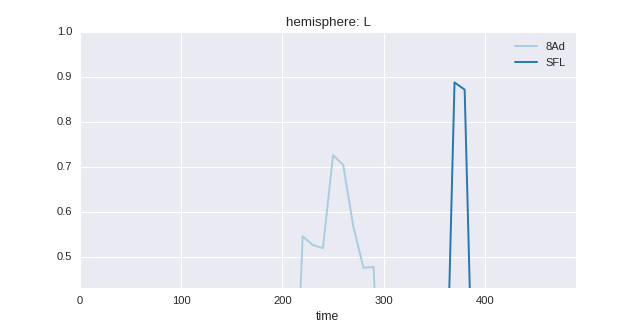

<IPython.core.display.Javascript object>


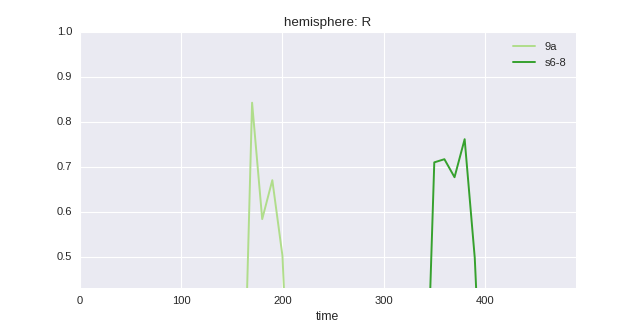

In [37]:
print(r_name)

region = 'dorso'

sv.show_timecourses(get_cluster_tcs(r_clusters[r_clusters.region.apply(lambda s: s.startswith(region))]), 
                    [threshold, ylims[measure]], logy=logy[measure])

### clusters associated with a particular area

accev


<IPython.core.display.Javascript object>


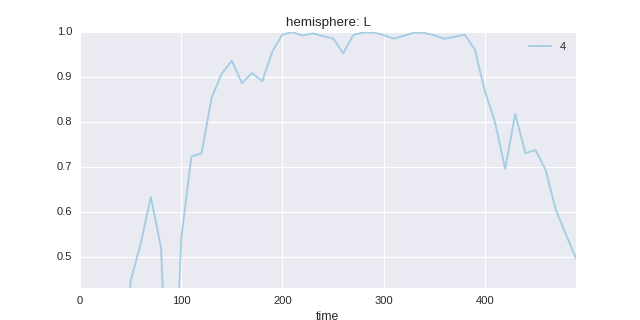

<IPython.core.display.Javascript object>


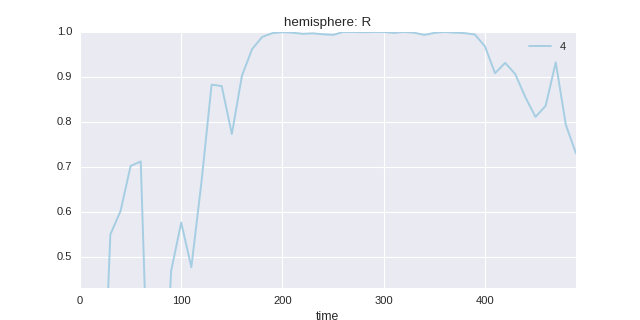

In [59]:
print(r_name)

# put the full area name in underscores such as '_1_' to match exactly
area = '_4_'

sv.show_timecourses(get_cluster_tcs(r_clusters[r_clusters.label.apply(lambda s: s.find(area)>0)]), 
                    [threshold, ylims[measure]], logy=logy[measure])

accev


<IPython.core.display.Javascript object>


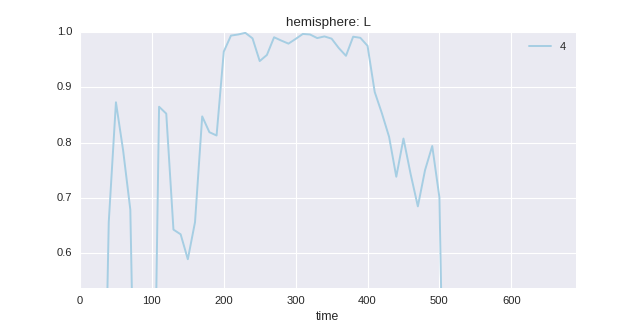

<IPython.core.display.Javascript object>


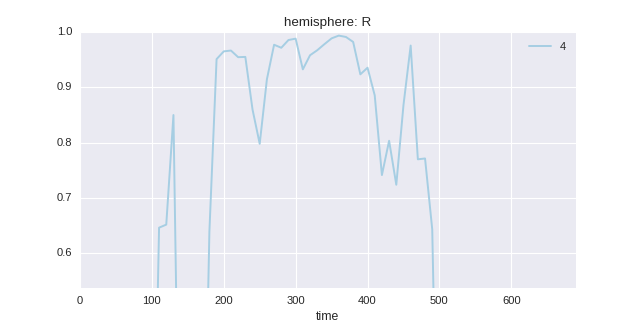

In [66]:
print(r_name)

# put the full area name in underscores such as '_1_' to match exactly
area = '_4_'

sv.show_timecourses(get_cluster_tcs(r_clusters[r_clusters.label.apply(lambda s: s.find(area)>0)]), 
                    [threshold, ylims[measure]], logy=logy[measure])

### clusters with reliable effect around a particular time

sum_dot_y_prev


<IPython.core.display.Javascript object>


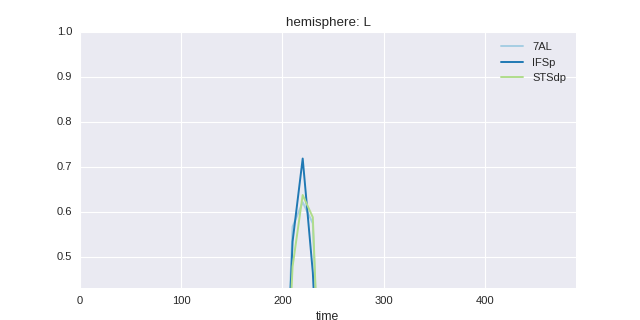

<IPython.core.display.Javascript object>


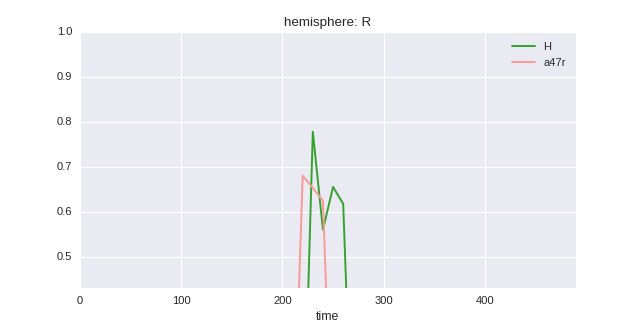

In [55]:
print(r_name)

time = 230

sv.show_timecourses(get_cluster_tcs(r_clusters[(time >= r_clusters.start_t) & (time <= r_clusters.end_t)]), 
                    [threshold, ylims[measure]], logy=logy[measure])

## Investigate consistency

In [15]:
src_df.loc[('L_8Ad_ROI-lh', 350)]

mu_mean         0.024773
mu_std          0.006247
mu_t            3.965776
mu_testval      0.001365
mu_p_large      0.791000
sigma_mean      0.024500
sigma_std       0.005728
theta_mean      0.802082
theta_std       0.102769
lp_mean        61.247414
lp_std          1.619361
overlap        -1.858091
consistency     0.691500
Name: (L_8Ad_ROI-lh, 350), dtype: float64

In [42]:
for cl in r_clusters.itertuples():
    r_clusters.loc[cl.Index, 'mean_consistency'] = (
        src_df.loc[(cl.label, slice(cl.start_t, cl.end_t)), 'consistency'].mean())
    r_clusters.loc[cl.Index, 'max_consistency'] = (
        src_df.loc[(cl.label, slice(cl.start_t, cl.end_t)), 'consistency'].max())

r_clusters[r_clusters.max_consistency < 0.5].sort_values('start_t')

,label,start_t,end_t,log10p,pval_corrected,region,mean_consistency,max_consistency
cluster,,,,,,,,
585,R_PSL_ROI-rh,40,60,-4.788280,8.779328e-05,temporo-parieto-occipital junction,0.381000,0.4280
520,R_LIPv_ROI-rh,60,80,-4.692145,1.069446e-04,superior parietal cortex,0.170333,0.2370
638,R_TGv_ROI-rh,70,90,-4.307668,2.279281e-04,lateral temporal cortex,0.298333,0.3975
588,R_PeEc_ROI-rh,80,100,-5.107361,4.438894e-05,medial temporal cortex,0.401500,0.4820
723,R_s32_ROI-rh,140,150,-3.718194,8.371139e-04,anterior cingulate and medial prefrontal cortex,0.411500,0.4670
524,R_LO3_ROI-rh,170,190,-5.258906,3.185792e-05,MT+ complex and neighboring visual areas,0.126500,0.1975
424,R_7Am_ROI-rh,180,220,-7.538750,2.434695e-07,superior parietal cortex,0.344800,0.4310
158,L_LIPv_ROI-lh,210,230,-4.620899,1.227705e-04,superior parietal cortex,0.354167,0.4245
264,L_TF_ROI-lh,260,280,-4.411059,1.883832e-04,lateral temporal cortex,0.327000,0.3710
